<a href="https://colab.research.google.com/github/CliffordDelaCruz/ML_study/blob/main/Audio_MNIST_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio MNIST Digit Recognition**

---------------------
## **Context**
---------------------

In the past decades, significant advances have been achieved in the area of audio recognition and a lot of research is going on globally to recognize audio data or speech using Deep Learning. The most common use case in this field is converting audio to spectrograms and vice versa. 

Audio in its raw form is usually a wave and to capture that using a data structure, we need to have a huge array of amplitudes even for a very short audio clip. Although it depends on the sampling rate of the sound wave, this structured data conversion for any audio wave is very voluminous even for low sampling rates. So it becomes a problem to store and computationally very expensive to do even simple calculations on such data.

One of the best economical alternatives to this is using spectrograms. Spectrograms are created by doing Fourier or Short Time Fourier Transforms on sound waves. There are various kinds of spectrograms but the ones we will be using are called MFCC spectrograms. To put it in simple terms, a spectrogram is a way to visually encapsulate audio data. It is a graph on a 2-D plane where the X-axis represents time and the Y-axis represents Mel Coefficients. But since it is continuous on a 2-D plane, we can treat this as an image.


---------------------
## **Objective**
---------------------

The objective here is to build an Artificial Neural Network that can look at Mel or MFCC spectrograms of audio files and classify them into 10 classes. The audio files are recordings of different speakers uttering a particular digit and the corresponding class to be predicted is the digit itself.

---------------------
## **Dataset**
---------------------

The dataset we will use is the **Audio MNIST dataset**, which has audio files (having .wav extension) stored in 10 different folders. Each folder consists of these digits spoken by a particular speaker.

## **Understanding the required packages**

* `Librosa`: Librosa is a Python package that helps in dealing with audio data. **librosa.display** visualizes and displays the audio data using Matplotlib. Similarly, there exists a collection of submodules under librosa that provides various other functionalities. **Run the command in the below cell to install the library**. 
* `IPython.display`: Display is a public API to display the tools available in Ipython. In this case study, we will create an audio object to display the digits in the MNIST audio data. 
* `tqdm`: tqdm is a Python package that allows us to add a progress bar to our application. This package will help us in iterating over the audio data. 

### **Installing Librosa**

In [1]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importing the necessary libraries and loading the data**

In [2]:
# For Audio Preprocessing
import librosa
import librosa.display as dsp
from IPython.display import Audio

# For Data Preprocessing
import pandas as pd
import numpy as np
import os

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#The data is provided as a zip file
import zipfile
import os

In [3]:
sns.set_style("dark")

### **Mounting the Drive and Unzipping the file**

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/Colab Notebooks/Audio_MNIST_Archive.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

### **Let's read and check some of the audio samples**

The below function called "get_audio" takes a digit as an argument and plots the audio wave and returns the audio for a given digit. 

Let's understand the functioning of some of the new functions used to create the get_audio() function.

* `.wav`: .wav is a file format like .csv which stores the raw audio format. We will load the .wav file using the librosa package. 
* `dsp.waveshow()`: It visualizes the waveform in the time domain. This method creates a plot that alternates between a raw samples-based view of the signal and an amplitude-envelope view of the signal. The "sr" parameter is the sampling rate, i.e., samples per second. 
* `Audio()`: From the Ipython package, we can create an audio object. 

In [7]:
def get_audio(digit = 0):

    # Audio Sample Directory
    sample = np.random.randint(1, 10)

    # Index of Audio
    index = np.random.randint(1, 5)
    
    # Modified file location
    if sample < 10:
        file = f"/content/data/0{sample}/{digit}_0{sample}_{index}.wav"

    else:
        file = f"/content/data/{sample}/{digit}_{sample}_{index}.wav"

    
    # Get Audio from the location
    # Audio will be automatically resampled to the given rate (default sr = 22050)
    data, sample_rate = librosa.load(file)
    
    # Plot the audio wave
    dsp.waveshow(data, sr = sample_rate)
    plt.show()
    
    # Show the widget
    return Audio(data = data, rate = sample_rate)

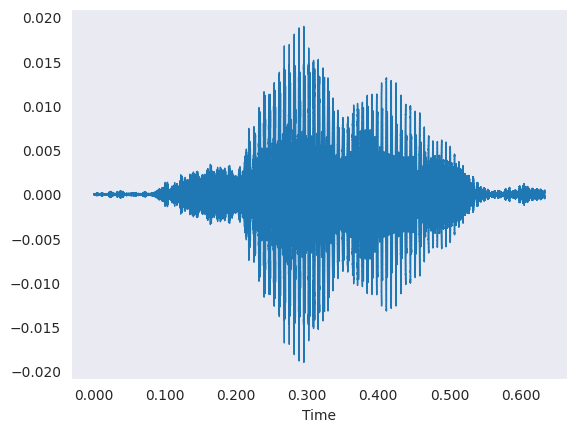

In [9]:
# Show the audio and plot of digit 0
get_audio(0)

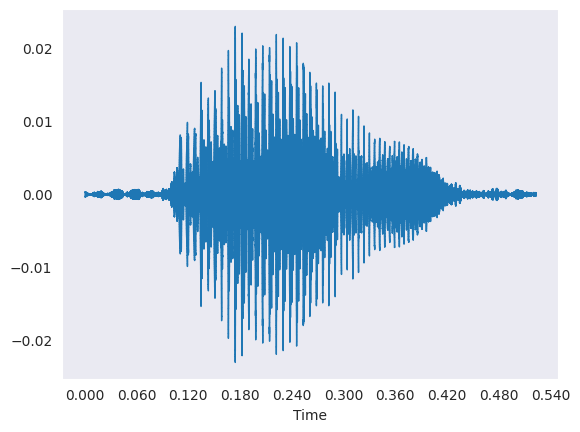

In [11]:
# Show the audio and plot of digit 1
get_audio(1)

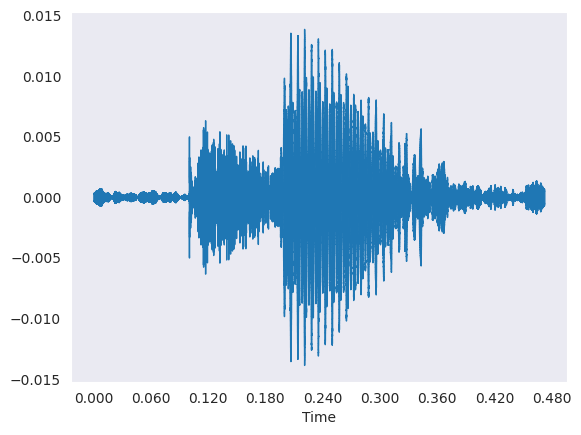

In [12]:
# Show the audio and plot of digit 2
get_audio(2)

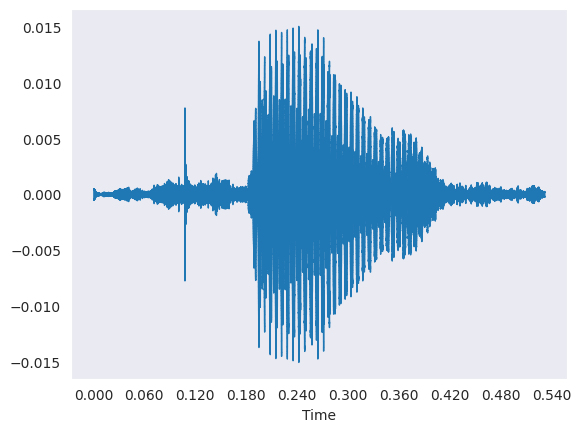

In [13]:
# Show the audio and plot of digit 3
get_audio(3)

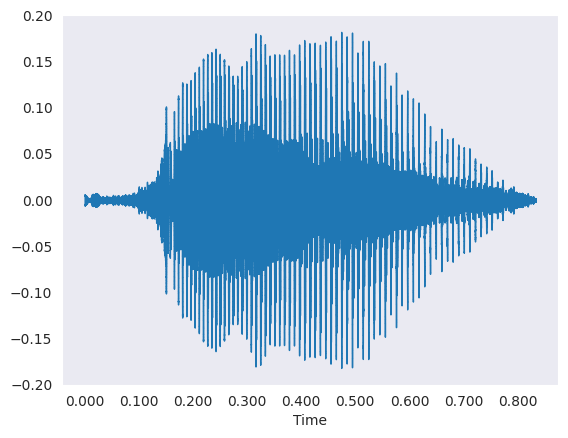

In [14]:
# Show the audio and plot of digit 4
get_audio(4)

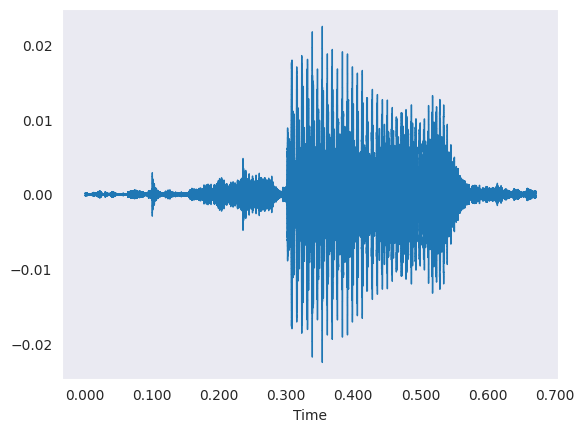

In [15]:
# Show the audio and plot of digit 5
get_audio(5)

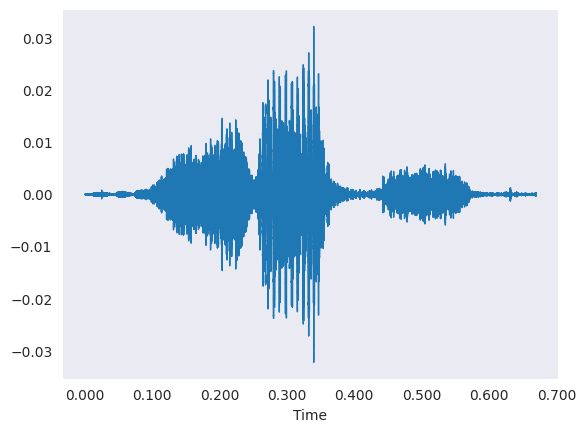

In [16]:
# Show the audio and plot of digit 6
get_audio(6)

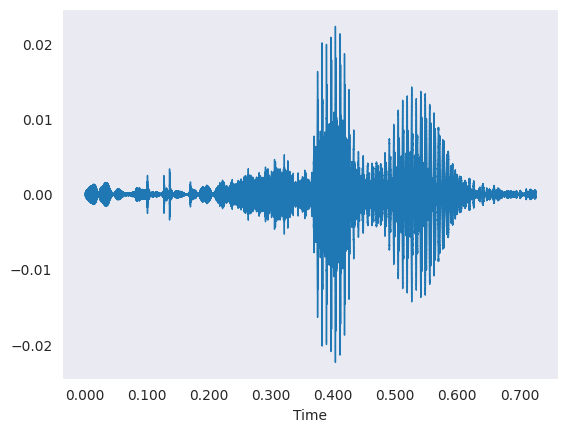

In [17]:
# Show the audio and plot of digit 7
get_audio(7)

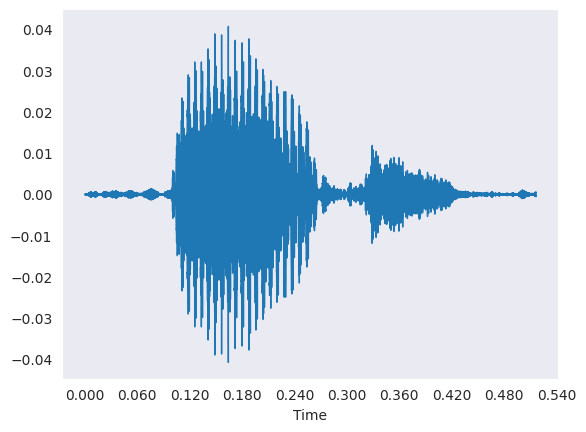

In [18]:
# Show the audio and plot of digit 8
get_audio(8)

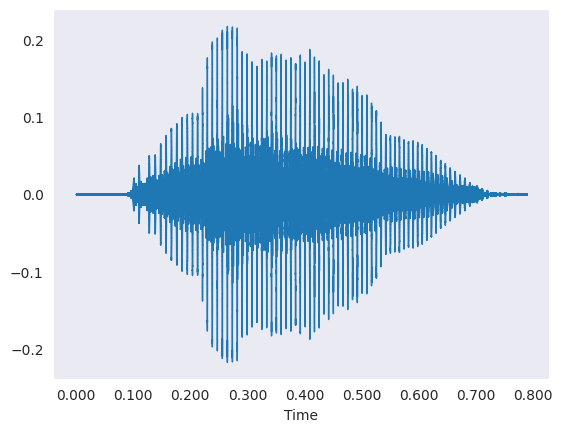

In [19]:
# Show the audio and plot of digit 9
get_audio(9)

**Observations:** 

- The X-axis represents time and Y-axis represents the amplitude of the vibrations. The intuition behind the Fourier Transform is that any wave can be broken down or deconstructed as a sum of many composite sine waves. Since these are composed of sine waves, they are symmetric about the time axis, i.e, they extend equally above and below the time axis at a particular time. 
- From the various audio plots ranging from 0 to 9, we can observe the amplitude at a given point in time. For example, when we say "Zero", the "Z" sound has low amplitude and the "ero" sound has higher amplitude. Similarly, the remaining digits can be interpreted by looking at the visualizations.

## **Visualizing the spectrogram of the audio data**

### **What is a spectrogram?**

A spectrogram is a visual way of representing the signal strength or “loudness” of a signal over time at various frequencies or time steps present in a particular waveform. A spectrogram gives a detailed view of audio. It represents amplitude, frequency, and time in a single plot. Since spectrograms are continuous plots, they can be interpreted as an image. Different spectrograms have different attributes on their axes and they are usually different to interpret. In a Research and Development scenario, we make use of a vocoder, which is an encoder that converts spectrograms back to audio using parameters learned by machine learning. One great vocoder is the WaveNet vocoder which is used in almost all Text to Speech architectures.

Here, we will be using **MFCC** spectrograms, which are also called **Mel** spectrograms.

In [20]:
# A function which returns audio file for a mentioned digit
def get_audio_raw(digit = 0):

    # Audio Sample Directory
    sample = np.random.randint(1, 10)

    # Index of Audio
    index = np.random.randint(1, 5)
    
    # Modified file location
    if sample < 10:
        file = f"/content/data/0{sample}/{digit}_0{sample}_{index}.wav"

    else:
        file = f"/content/data/{sample}/{digit}_{sample}_{index}.wav"

    
    # Get Audio from the location
    data, sample_rate = librosa.load(file)

    # Return audio
    return data, sample_rate

### **Extracting features from the audio file**

**Mel-frequency cepstral coefficients (MFCCs) Feature Extraction**

MFCCs are usually the final features used in many machine learning models trained on audio data. They are usually a set of mel coefficients defined for each time step through which the raw audio data can be encoded. So for example, if we have an audio sample extending for 30 time steps, and we are defining each time step by 40 Mel Coefficients, our entire sample can be represented by 40 * 30 Mel Coefficients. And if we want to create a Mel Spectrogram out of it, our spectrogram will resemble a 2-D array of 40 horizontal rows and 30 vertical columns.

In this time step, we will first extract the Mel Coefficents for each audio file and add them to our dataset.

* `extract_features` : Returns the MFCC extracted features for an audio file. 
* `process_and_create_dataset` : Iterate through the audio of each digit, extract the features using the extract_features() function, and append the data into a DataFrame. 

**Creating a function that extracts the data from audio files**

In [21]:
# Will take an audio file as input and return extracted features using MEL_FREQUENCY CEPSTRAL COEFFICIENT as the output
def extract_features(file):

    # Load audio and its sample rate
    audio, sample_rate = librosa.load(file)

    # Extract features using mel-frequency coefficient
    extracted_features = librosa.feature.mfcc(y = audio,
                                              sr = sample_rate,
                                              n_mfcc = 40)
    
    # Scale the extracted features
    extracted_features = np.mean(extracted_features.T, axis = 0)

    # Return the extracted features
    return extracted_features


def preprocess_and_create_dataset():

    # Path of the folder where the audio files are present
    root_folder_path = "/content/data/"

    # Empty List to create dataset
    dataset = []
    
    # Iterating through folders where each folder has the audio of each digit
    for folder in tqdm(range(1, 11)):

        if folder < 10:

            # Path of the folder
            folder = os.path.join(root_folder_path, "0" + str(folder))

        else:
            folder = os.path.join(root_folder_path, str(folder))
            
        # Iterate through each file of the present folder
        for file in tqdm(os.listdir(folder)):

            # Path of the file
            abs_file_path = os.path.join(folder, file)

            # Pass path of file to the extracted_features() function to create features
            extracted_features = extract_features(abs_file_path) 

            # Class of the audio, i.e., the digit it represents
            class_label = file[0]
            
            # Append a list where the feature represents a column and class of the digit represents another column
            dataset.append([extracted_features, class_label])
    
    # After iterating through all the folders, convert the list to a DataFrame
    return pd.DataFrame(dataset, columns = ['features', 'class'])

**Now. let's create the dataset using the defined function**

In [22]:
# Create the dataset by calling the function
dataset = preprocess_and_create_dataset()

100%|██████████| 10/10 [01:11<00:00,  7.11s/it]


**View first 5 rows of the data**

In [23]:
# View the head of the DataFrame
dataset.head()

,features,class
0,"[-600.01666, 113.85479, 9.068147, 10.023492, 5...",4
1,"[-576.64984, 98.217155, -7.6343, 26.481337, 19...",5
2,"[-628.047, 104.64607, 13.162712, 25.435207, 22...",0
3,"[-601.5934, 113.23821, 5.2569456, 8.741453, 9....",4
4,"[-628.2019, 100.137024, 22.538715, 23.49066, 2...",2


In [24]:
# Storing the class as int 
dataset['class'] = [int(x) for x in dataset['class']]

In [25]:
# Check the frequency of classes in the dataset
dataset['class'].value_counts()

4    500
5    500
0    500
2    500
8    500
9    500
3    500
1    500
6    500
7    500
Name: class, dtype: int64

### **Visualizing the Mel Frequency Cepstral Coefficients Using a Spectrogram**

* `draw_spectrograms` : From the Mel Coefficients we are extracting for a particular audio, this function is creating the 2-D graph of those coefficients with the X-axis representing time and the Y-axis shows the corresponding Mel coefficients in that time step. 

In [26]:
# A function which returns MFCC
def draw_spectrograms(audio_data, sample_rate):

    # Extract features
    extracted_features = librosa.feature.mfcc(y = audio_data,
                                              sr = sample_rate,
                                              n_mfcc = 40)
    
    # Return features without scaling
    return extracted_features

The very first MFCC coefficient (0th coefficient) does not provide information about the overall shape of the spectrum. It simply communicates a constant offset or the addition of a constant value to the full spectrum. As a result, when performing classification, many practitioners will disregard the initial MFCC. In the images, you can see those represented by blue pixels.

We can plot the MFCCs, but it's difficult to tell what kind of signal is hiding behind such representation.

Shape of MFCC of audio digit 0 --->  (40, 27)
Shape of MFCC of audio digit 1 --->  (40, 21)
Shape of MFCC of audio digit 2 --->  (40, 22)
Shape of MFCC of audio digit 3 --->  (40, 29)
Shape of MFCC of audio digit 4 --->  (40, 24)
Shape of MFCC of audio digit 5 --->  (40, 26)
Shape of MFCC of audio digit 6 --->  (40, 30)
Shape of MFCC of audio digit 7 --->  (40, 35)
Shape of MFCC of audio digit 8 --->  (40, 25)
Shape of MFCC of audio digit 9 --->  (40, 28)


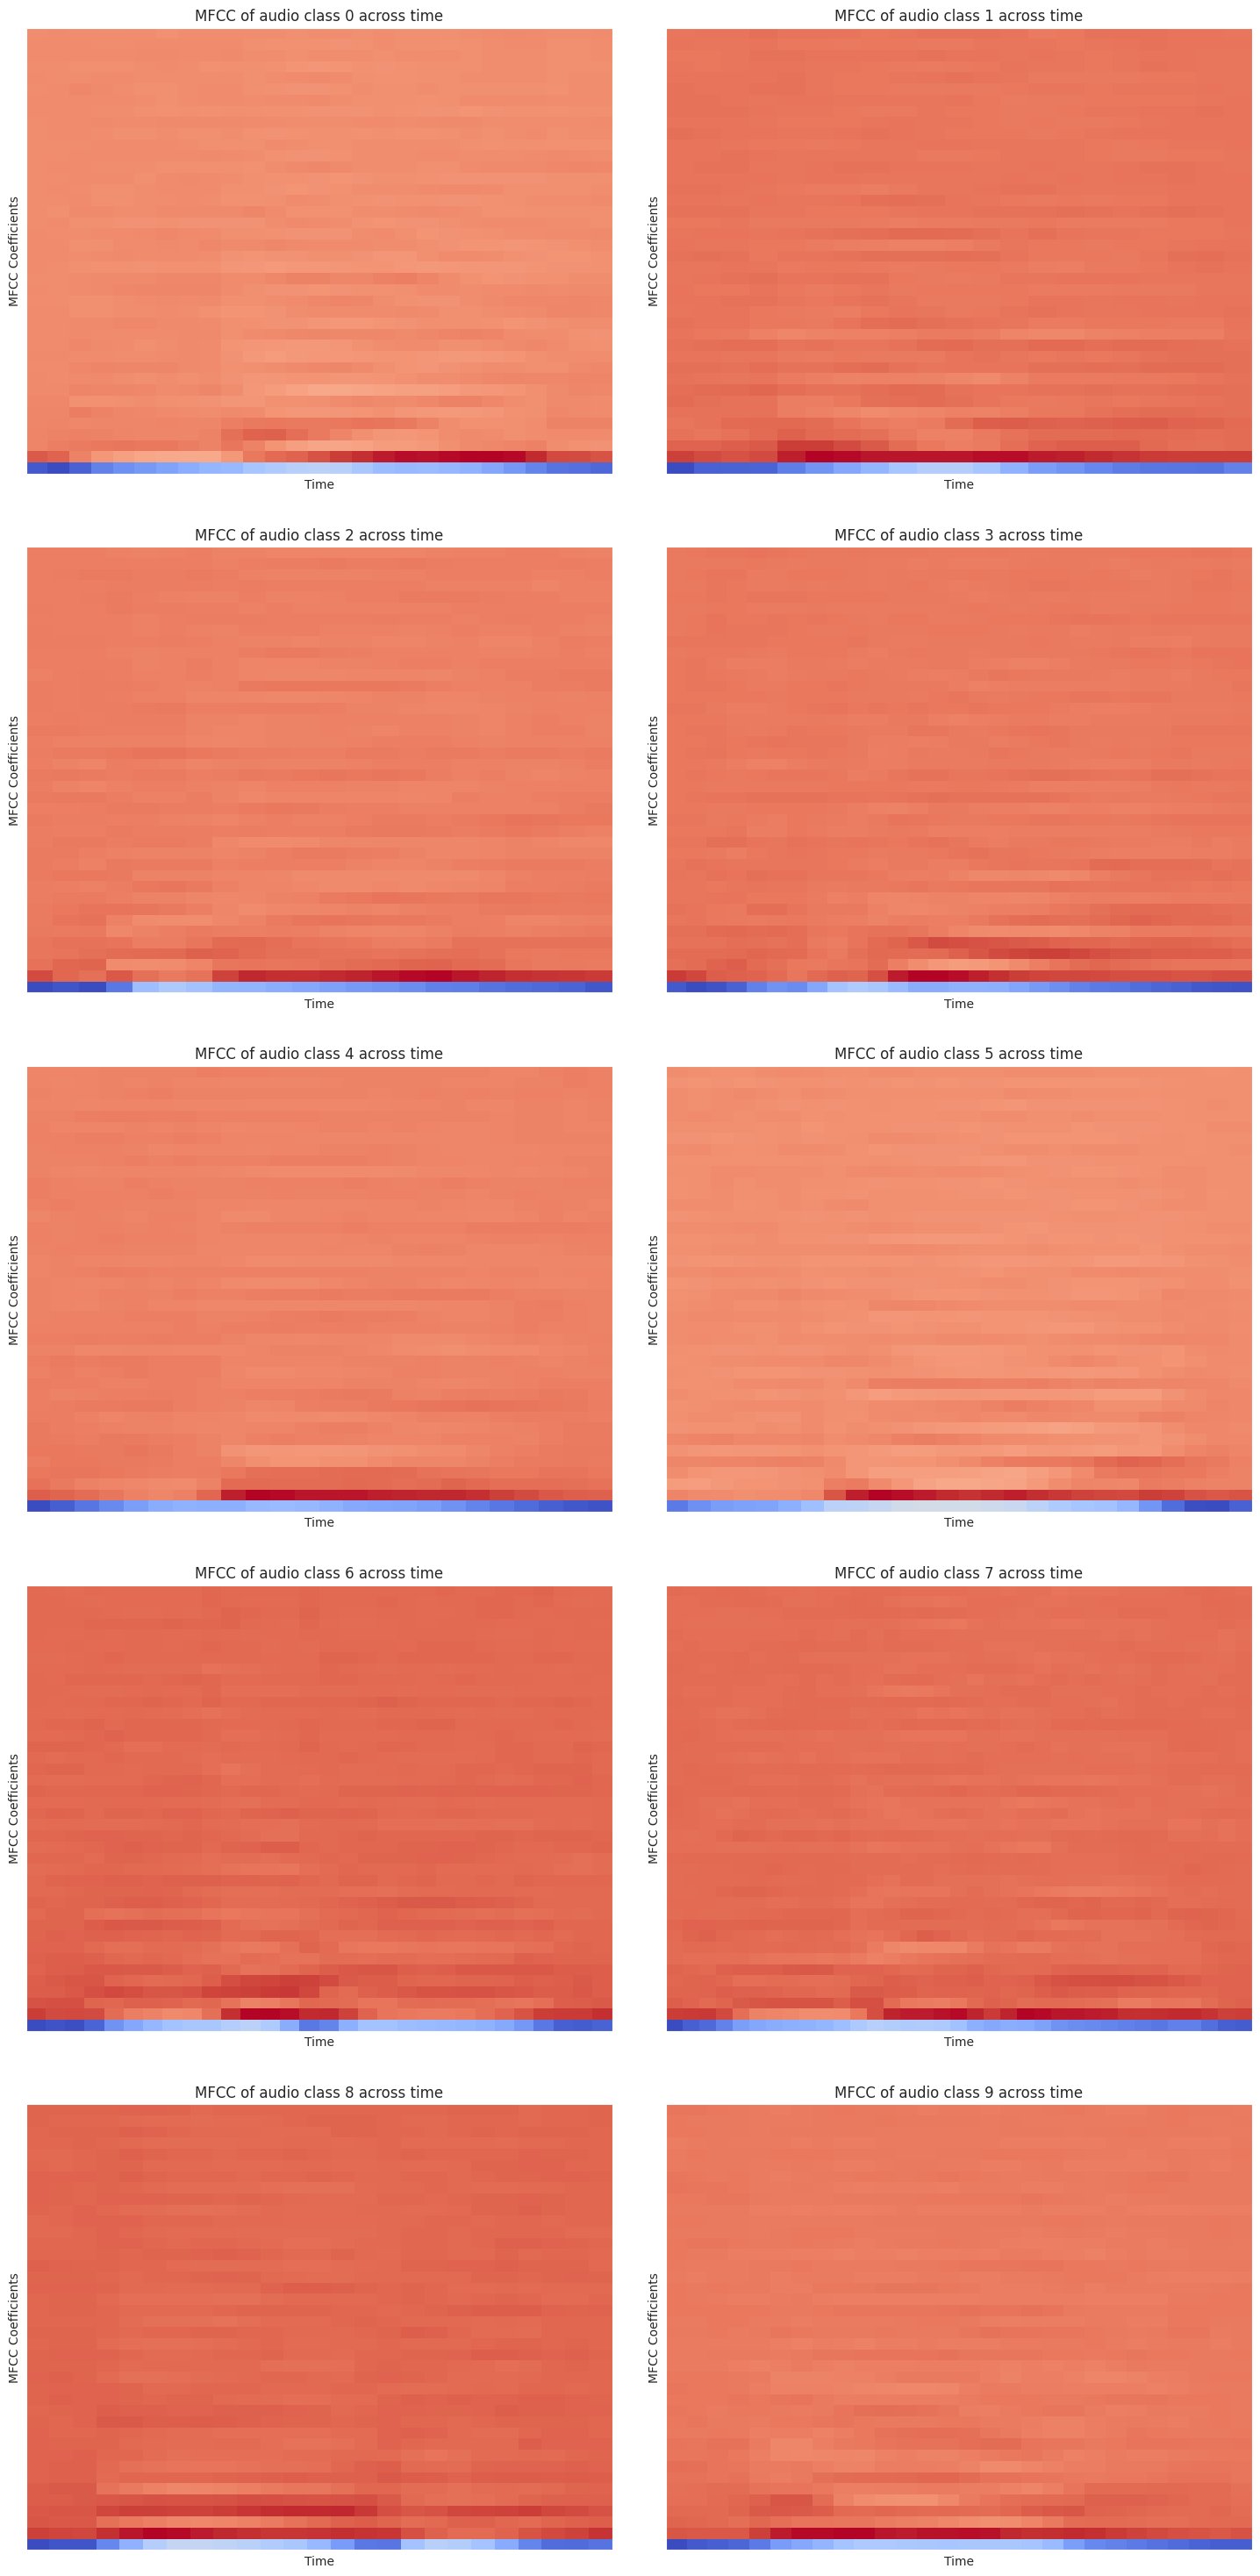

In [27]:
# Creating subplots
fig, ax = plt.subplots(5, 2, figsize = (15, 30))

# Initializing row and column variables for subplots
row = 0
column = 0

for digit in range(10):

    # Get the audio of different classes (0-9)
    audio_data, sample_rate = get_audio_raw(digit)
    
    # Extract their MFCC
    mfcc = draw_spectrograms(audio_data, sample_rate)
    print(f"Shape of MFCC of audio digit {digit} ---> ", mfcc.shape)
    
    # Display the plots and its title
    ax[row,column].set_title(f"MFCC of audio class {digit} across time")
    librosa.display.specshow(mfcc, sr = 22050, ax = ax[row, column])
    
    # Set X-labels and Y-labels
    ax[row,column].set_xlabel("Time")
    ax[row,column].set_ylabel("MFCC Coefficients")
    
    # Conditions for positioning of the plots
    if column == 1:
        column = 0
        row += 1
    else:
        column+=1
        
    
plt.tight_layout(pad = 3)   
plt.show()

**Visual Inspection of MFCC Spectrograms:**

On inspecting them visually, we can see that there are a lot of deviations from the spectrograms of one audio to another. There are a lot of tiny rectangles and bars whose positions are unique to each audio. So, the Artificial Neural Network should be able to perform decently in identifying these audios.

## **Perform Train-Test-Split**

- Split the data into train and test sets

In [28]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X = np.array(dataset['features'].to_list())
Y = np.array(dataset['class'].to_list())

# Create train set and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.75, shuffle = True, random_state = 8)

In [29]:
# Checking the shape of the data
X_train.shape

(3750, 40)

## **Modelling**

- Create an artificial neural network to recognize the digit. 

**About the libraries:** 

- `Keras`: Keras is an open-source deep-learning library in Python. Keras is popular because the API was clean and simple, allowing standard deep learning models to be defined, fit, and evaluated in just a few lines of code.
- `Sklearn` :
   * Simple and efficient tools for predictive data analysis
   * Accessible to everybody, and reusable in various contexts
   * Built on NumPy, SciPy, and matplotlib
   * Open source, commercially usable

### **Import necessary libraries for building the model**

In [30]:
# To create an ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# To create a checkpoint and save the best model
from tensorflow.keras.callbacks import ModelCheckpoint

# To load the model
from tensorflow.keras.models import load_model

# To evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

## **Model Creation**


### **Why are we using ANN's?**


When we are converting audios to their corresponding spectrograms, we will have similar spectrograms for similar audios irrespective of who the speaker is, and what is their pitch and timber like. So local spatiality is never going to be a problem. So having convolutional layers on top of our fully connected layers is just adding to our computational redundancy.

We will use a Sequential model with multiple connected hidden layers, and an output layer that returns a single, continuous value.

- A Sequential model is a linear stack of layers. Sequential models can be created by giving a list of layer instances. 
- A dense layer of neurons is a simple layer of neurons in which each neuron receives input from all of the neurons in the previous layer.
- The most popular function employed for hidden layers is the rectified linear activation function, or ReLU activation function. It's popular because it's easy to use and effective in getting around the limitations of other popular activation functions like Sigmoid and Tanh.

In [31]:
# Crete a Sequential Object
model = Sequential()

# Add first layer with 100 neurons to the sequental object
model.add(Dense(100, input_shape = (40, ), activation = 'relu'))

# Add second layer with 100 neurons to the sequental object
model.add(Dense(100, activation = 'relu'))

# Add third layer with 100 neurons to the sequental object
model.add(Dense(100, activation = 'relu'))

# Output layer with 10 neurons as it has 10 classes
model.add(Dense(10, activation = 'softmax'))

In [32]:
# Print Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 25,310
Trainable params: 25,310
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'adam')

### **Model Checkpoint & Training**

In [34]:
# Set the number of epochs for training
num_epochs = 100

# Set the batch size for training
batch_size = 32

# Fit the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = num_epochs, batch_size = batch_size, verbose = 1)

Epoch 1/100
118/118 [==============================] - 2s 7ms/step - loss: 2.9974 - accuracy: 0.4624 - val_loss: 0.8153 - val_accuracy: 0.6960
Epoch 2/100
118/118 [==============================] - 0s 4ms/step - loss: 0.5775 - accuracy: 0.8013 - val_loss: 0.6498 - val_accuracy: 0.7832
Epoch 3/100
118/118 [==============================] - 0s 3ms/step - loss: 0.3277 - accuracy: 0.8861 - val_loss: 0.2232 - val_accuracy: 0.9328
Epoch 4/100
118/118 [==============================] - 0s 3ms/step - loss: 0.2239 - accuracy: 0.9283 - val_loss: 0.2099 - val_accuracy: 0.9328
Epoch 5/100
118/118 [==============================] - 0s 3ms/step - loss: 0.1702 - accuracy: 0.9413 - val_loss: 0.1491 - val_accuracy: 0.9576
Epoch 6/100
118/118 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.9347 - val_loss: 0.1509 - val_accuracy: 0.9424
Epoch 7/100
118/118 [==============================] - 0s 3ms/step - loss: 0.1173 - accuracy: 0.9600 - val_loss: 0.1328 - val_accuracy: 0.9600

### **Model Evaluation**

In [35]:
# Make predictions on the test set
Y_pred = model.predict(X_test)
Y_pred = [np.argmax(i) for i in Y_pred]

40/40 [==============================] - 0s 1ms/step


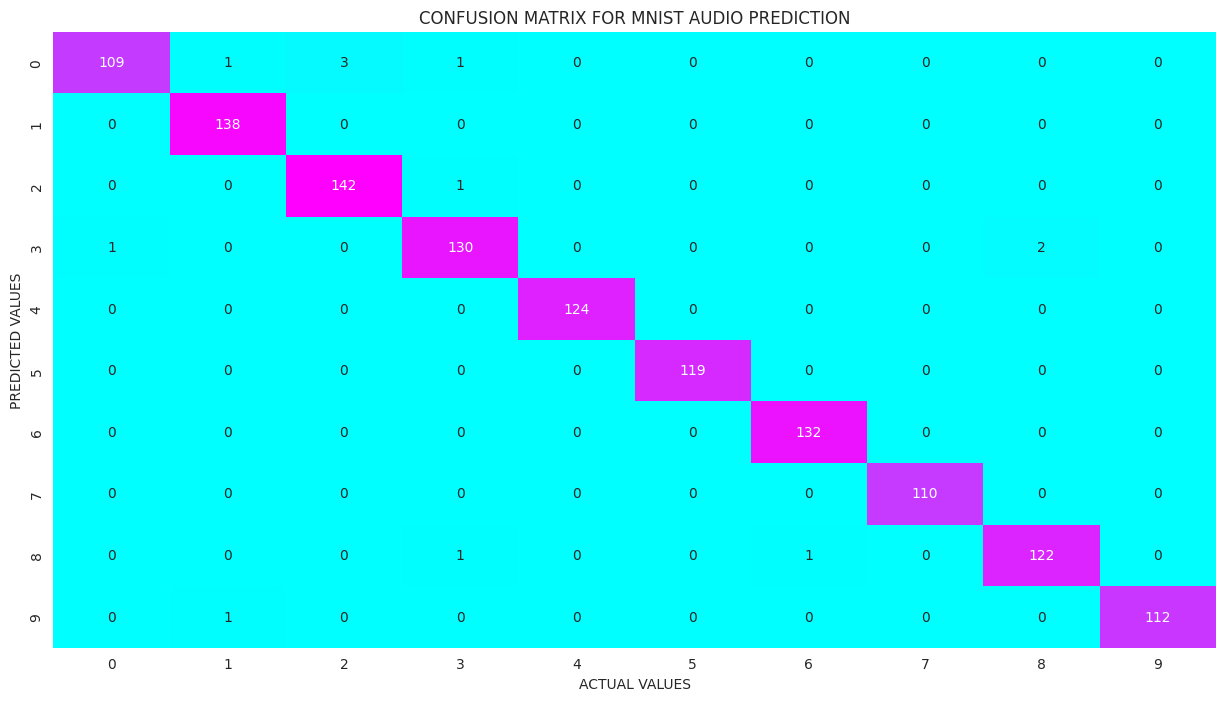

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       114
           1       0.99      1.00      0.99       138
           2       0.98      0.99      0.99       143
           3       0.98      0.98      0.98       133
           4       1.00      1.00      1.00       124
           5       1.00      1.00      1.00       119
           6       0.99      1.00      1.00       132
           7       1.00      1.00      1.00       110
           8       0.98      0.98      0.98       124
           9       1.00      0.99      1.00       113

    accuracy                           0.99      1250
   macro avg       0.99      0.99      0.99      1250
weighted avg       0.99      0.99      0.99      1250



In [36]:
# Set style as dark
sns.set_style("dark")

# Set figure size
plt.figure(figsize = (15, 8))

# Plot the title
plt.title("CONFUSION MATRIX FOR MNIST AUDIO PREDICTION")

# Confusion matrix
cm = confusion_matrix([int(x) for x in Y_test], Y_pred)

# Plot the confusion matrix as heatmap
sns.heatmap(cm, annot = True, cmap = "cool", fmt = 'g', cbar = False)

# Set X-label and Y-label
plt.xlabel("ACTUAL VALUES")
plt.ylabel("PREDICTED VALUES")

# Show the plot
plt.show()

# Print the metrics
print(classification_report(Y_test, Y_pred))

**Observations:**

- From the confusion matrix, we can observe that most of the observations are correctly identified by the model. 
- In very few cases, the model is not able to identify the correct digit. For example, 9 observations are 0 but the model has predicted them as 2. 
- The model has given a great performance with 99% recall, precision and F1-score. 